<a href="https://www.kaggle.com/code/jiejian925/delivery-analysis-by-python?scriptVersionId=103723079" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
customers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
order_items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
olist_geolocation = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')
orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
order_payments = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


## Check the data and data clean

In [3]:
olist_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [4]:
olist_geolocation.describe()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1.000163e+06,1.000163e+06,1.000163e+06
mean,3.657417e+04,-2.117615e+01,-4.639054e+01
std,3.054934e+04,5.715866e+00,4.269748e+00
min,1.001000e+03,-3.660537e+01,-1.014668e+02
25%,1.107500e+04,-2.360355e+01,-4.857317e+01
50%,2.653000e+04,-2.291938e+01,-4.663788e+01
75%,6.350400e+04,-1.997962e+01,-4.376771e+01
max,9.999000e+04,4.506593e+01,1.211054e+02


In [5]:
olist_geolocation['geolocation_city'].unique()

array(['sao paulo', 'são paulo', 'sao bernardo do campo', ..., 'ciríaco',
       'estação', 'vila lângaro'], dtype=object)

In [6]:
# Revise city name são paulo to sao paulo
olist_geolocation.replace(to_replace='são paulo',value='sao paulo',inplace=True)

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [8]:
# change date columns from object to date
orders[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']] = orders[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [10]:
# Only Delivery shipments could check the delivery time
delivered = orders[orders['order_status']=='delivered'].dropna()

In [11]:
# undelivered shipments
undelivered = orders[orders['order_status']!='delivered']

In [12]:
# check the undelivered_rate
undelivered_rate = undelivered['order_id'].count()/orders['order_id'].count()
print("undelivered_rate : %5.2f" % undelivered_rate)

undelivered_rate :  0.03


In [13]:
total = undelivered['order_id'].count()
not_approve = undelivered['order_approved_at'].isna().sum()
not_shipped = undelivered['order_delivered_carrier_date'].isna().sum() - undelivered['order_approved_at'].isna().sum()
not_delivered = undelivered['order_delivered_customer_date'].isna().sum() - undelivered['order_delivered_carrier_date'].isna().sum()
print("not_approve_rate : %5.2f, not_shipped_rate : %5.2f, not_delivered_rate : %5.2f" % (not_approve/total,not_shipped/total,not_delivered/total))

not_approve_rate :  0.05, not_shipped_rate :  0.55, not_delivered_rate :  0.40


Text(0.5, 1.0, 'Reason of undelivered orders')

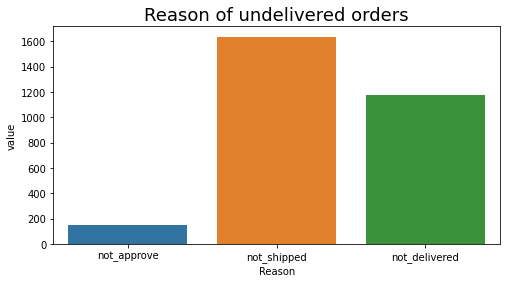

In [14]:
lst1 = ['not_approve', 'not_shipped','not_delivered']
lst2 = [not_approve, not_shipped, not_delivered] 
df = pd.DataFrame(list(zip(lst1, lst2)), columns =['Reason', 'value']) 
fig = plt.subplots(figsize=(8, 4))
sns.barplot(x='Reason',y='value',data=df).set_title('Reason of undelivered orders', fontsize=18)

## Combine data in one file

In [15]:
data_delivered = pd.merge(delivered,customers,on='customer_id',how='left')

In [16]:
orders_products = pd.merge(order_items,data_delivered,on='order_id',how='left')

In [17]:
products = pd.merge(orders_products,products,on='product_id',how='left')

In [18]:
data = pd.merge(products,order_payments,on='order_id',how='left')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117604 entries, 0 to 117603
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117604 non-null  object        
 1   order_item_id                  117604 non-null  int64         
 2   product_id                     117604 non-null  object        
 3   seller_id                      117604 non-null  object        
 4   shipping_limit_date            117604 non-null  object        
 5   price                          117604 non-null  float64       
 6   freight_value                  117604 non-null  float64       
 7   customer_id                    115014 non-null  object        
 8   order_status                   115014 non-null  object        
 9   order_purchase_timestamp       115014 non-null  datetime64[ns]
 10  order_approved_at              115014 non-null  datetime64[ns]
 11  

In [20]:
data['shipping_limit_date']=pd.to_datetime(data['shipping_limit_date'])

In [21]:
# Export data,csv to data visiulization on Tableau
import os
os.makedirs(r'C:\Users\apolo\Desktop', exist_ok=True)  
data.to_csv(r'C:\Users\apolo\Desktop\delivered.csv')  

In [22]:
len(data['customer_city'].unique())

4086

In [23]:
city_top30 = data['customer_city'].value_counts().head(30)
city_top30

sao paulo                18161
rio de janeiro            7948
belo horizonte            3188
brasilia                  2405
curitiba                  1785
campinas                  1707
porto alegre              1614
salvador                  1473
guarulhos                 1363
sao bernardo do campo     1093
niteroi                   1027
santo andre                896
osasco                     866
santos                     835
goiania                    834
sao jose dos campos        796
fortaleza                  728
sorocaba                   712
recife                     683
jundiai                    670
florianopolis              669
ribeirao preto             593
contagem                   503
nova iguacu                503
belem                      498
juiz de fora               488
barueri                    483
mogi das cruzes            474
sao goncalo                449
uberlandia                 430
Name: customer_city, dtype: int64

## Data visiulization on orders distribution

Text(0, 0.5, 'No. of orders')

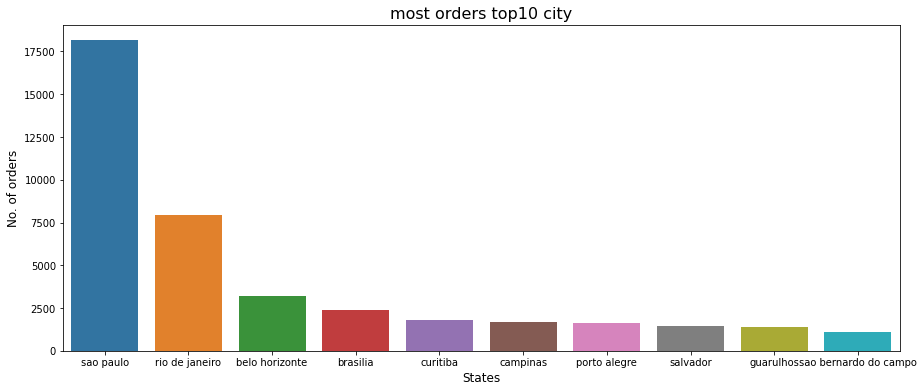

In [24]:
# Visualize the most orders top10 city
city10 = list(data['customer_city'].value_counts().sort_values(ascending=False).head(10).index)
city10_analysis=data[data['customer_city'].isin(city10)]

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(x='customer_city', data=city10_analysis, ax=ax,order = city10_analysis['customer_city'].value_counts().index)
ax.set_title('most orders top10 city', fontsize=16)
ax.set_xlabel('States', fontsize=12)
ax.set_ylabel('No. of orders', fontsize=12)


Text(0, 0.5, 'No. of orders')

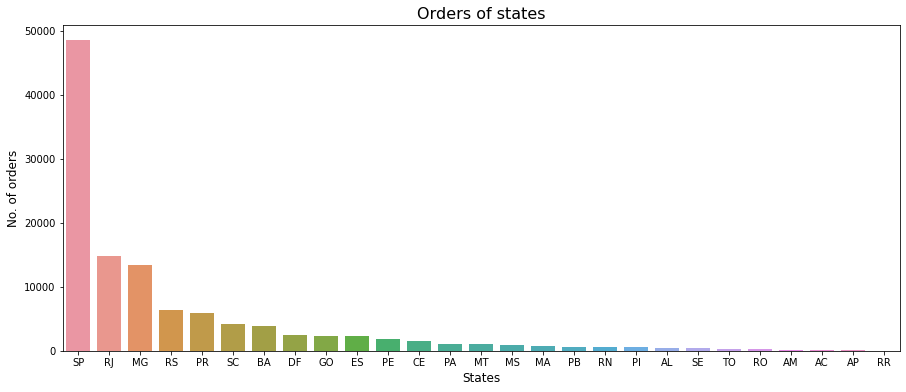

In [25]:
# Visualize Orders of states
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(x='customer_state', data=data, ax=ax, order = data['customer_state'].value_counts().index)
ax.set_title('Orders of states', fontsize=16)
ax.set_xlabel('States', fontsize=12)
ax.set_ylabel('No. of orders', fontsize=12)

## Extract key factors for evaluating delivery performance

In [26]:
delivery_analysis = data[['order_id','product_id','shipping_limit_date','price', 'freight_value','order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date','customer_city','product_weight_g','payment_value']]
delivered_analysis = delivery_analysis[delivery_analysis['order_delivered_customer_date'].notnull()]
delivered_analysis['processing time'] = (delivered_analysis['order_delivered_carrier_date'] - delivered_analysis['order_purchase_timestamp']).astype('timedelta64[D]')
delivered_analysis['delay_processing_time'] = (delivered_analysis['shipping_limit_date'] - delivered_analysis['order_delivered_carrier_date']).astype('timedelta64[D]')
delivered_analysis['shipping time'] = (delivered_analysis['order_delivered_customer_date'] - delivered_analysis['order_delivered_carrier_date']).astype('timedelta64[D]')
delivered_analysis['delivery_time'] = (delivered_analysis['order_delivered_customer_date'] - delivered_analysis['order_purchase_timestamp']).astype('timedelta64[D]')
delivered_analysis['Month'] = delivered_analysis['order_purchase_timestamp'].apply(lambda x: x.month)
delivered_analysis['Year'] = delivered_analysis['order_purchase_timestamp'].apply(lambda x: x.year)
delivered_analysis = delivered_analysis[delivered_analysis['processing time']>=0]

In [27]:
delivered_analysis.head()

,order_id,product_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,product_weight_g,payment_value,processing time,delay_processing_time,shipping time,delivery_time,Month,Year
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,2017-09-19 09:45:35,58.90,13.29,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,campos dos goytacazes,650.0,72.19,6.0,-1.0,1.0,7.0,9,2017
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,2017-05-03 11:05:13,239.90,19.93,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,santa fe do sul,30000.0,259.83,8.0,-2.0,8.0,16.0,4,2017
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,para de minas,3050.0,216.87,1.0,2.0,6.0,7.0,1,2018
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,atibaia,200.0,25.78,2.0,4.0,4.0,6.0,8,2018
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,2017-02-13 13:57:51,199.90,18.14,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,varzea paulista,3750.0,218.04,11.0,-3.0,13.0,25.0,2,2017


## Data visiulization on Delivery Performance

<AxesSubplot:xlabel='delivery_time', ylabel='count'>

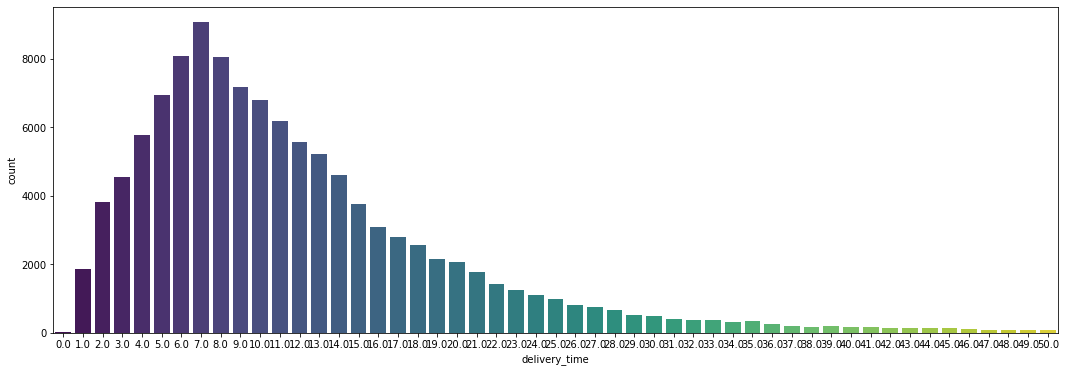

In [28]:
# countplot of delivery performance 
fig, ax = plt.subplots(figsize=(18,6))
sns.countplot(x='delivery_time',data=delivered_analysis[delivered_analysis['delivery_time']<=50],palette='viridis',ax=ax)

Text(0, 0.5, 'No. of orders')

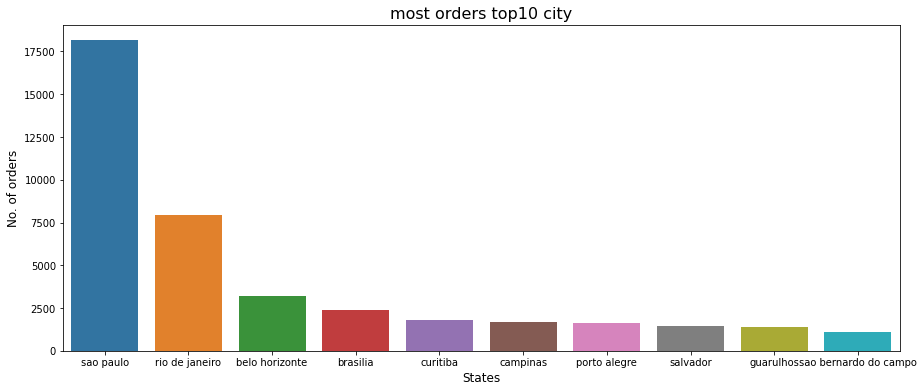

In [29]:
# Visualize the most orders top10 city
city10 = list(data['customer_city'].value_counts().sort_values(ascending=False).head(10).index)
city10_analysis=data[data['customer_city'].isin(city10)]

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(x='customer_city', data=city10_analysis, ax=ax,order = city10_analysis['customer_city'].value_counts().index)
ax.set_title('most orders top10 city', fontsize=16)
ax.set_xlabel('States', fontsize=12)
ax.set_ylabel('No. of orders', fontsize=12)

Text(0, 0.5, 'No. of orders')

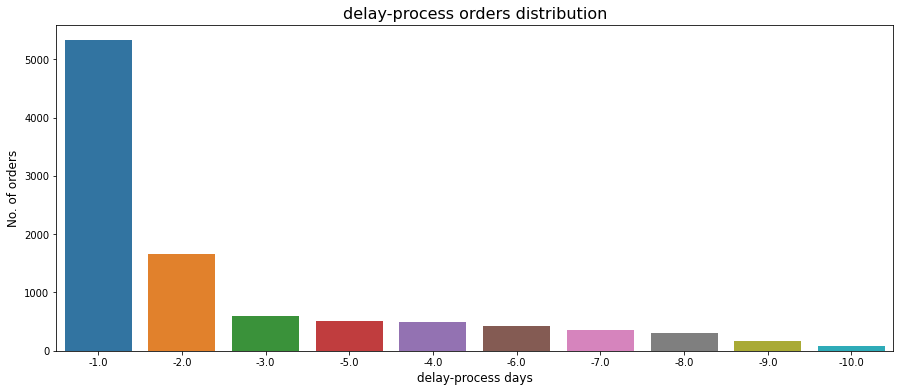

In [30]:
# Visualize the delay-process orders distribution
delay_process=list(delivered_analysis[delivered_analysis['delay_processing_time']<0]['delay_processing_time'].value_counts().head(10).index)
delay_process_analysis = delivered_analysis[delivered_analysis['delay_processing_time'].isin(delay_process)]
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(x='delay_processing_time', data=delay_process_analysis, ax=ax,order = delay_process_analysis['delay_processing_time'].value_counts().index)
ax.set_title('delay-process orders distribution', fontsize=16)
ax.set_xlabel('delay-process days', fontsize=12)
ax.set_ylabel('No. of orders', fontsize=12)

Text(0, 0.5, 'No. of orders')

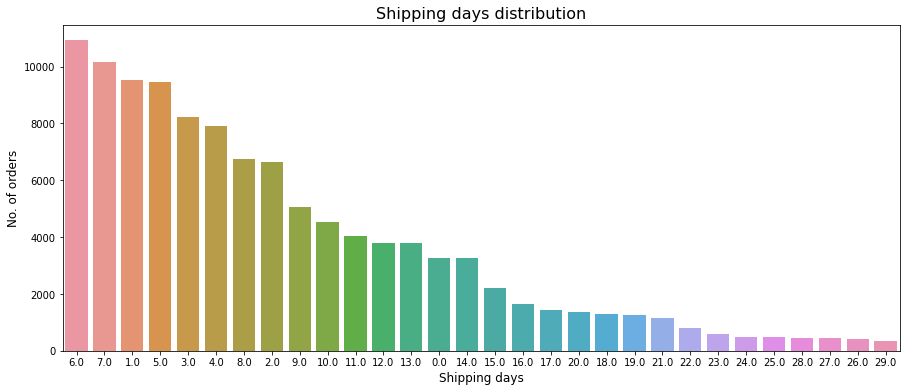

In [31]:
# Visualize the shipping days distribution
ship30 = list(delivered_analysis['shipping time'].value_counts().sort_values(ascending=False).head(30).index)
ship30_analysis=delivered_analysis[delivered_analysis['shipping time'].isin(ship30)]
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(x='shipping time', data=ship30_analysis, ax=ax,order = ship30_analysis['shipping time'].value_counts().index)
ax.set_title('Shipping days distribution', fontsize=16)
ax.set_xlabel('Shipping days', fontsize=12)
ax.set_ylabel('No. of orders', fontsize=12)

## Analyze relationship with on time delivery and other variables
variable: customer_city,price,freight_value, Month, processing time,shipping time

In [32]:
# Considering delivered in 10 days is on time, otherwise delay
delivered_analysis['On_Time']=delivered_analysis['delivery_time'].apply(lambda x:1 if x <= 10 else 0)

In [33]:
ontime = delivered_analysis['On_Time'].sum()
al = delivered_analysis['On_Time'].count()
print("ontime_rate : %5.2f" % (ontime/al))

ontime_rate :  0.54


In [34]:
dataset=delivered_analysis[['price','customer_city','product_weight_g','Month','processing time','shipping time','On_Time','Year']].dropna()

<AxesSubplot:>

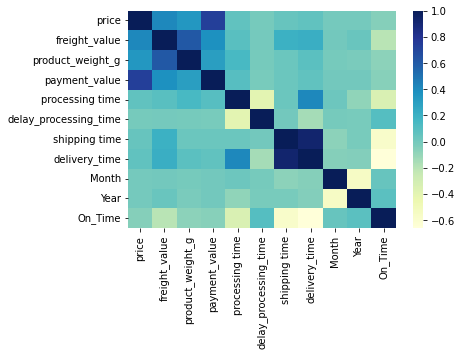

In [35]:
correlation = delivered_analysis.corr()
sns.heatmap(correlation,cmap="YlGnBu")
# Delay Processing Time has reveser impact on processing time, that's make sense
# prodcut weight, freight_value and payment_value has corrlection.

### On-time rate is getting better by Years.

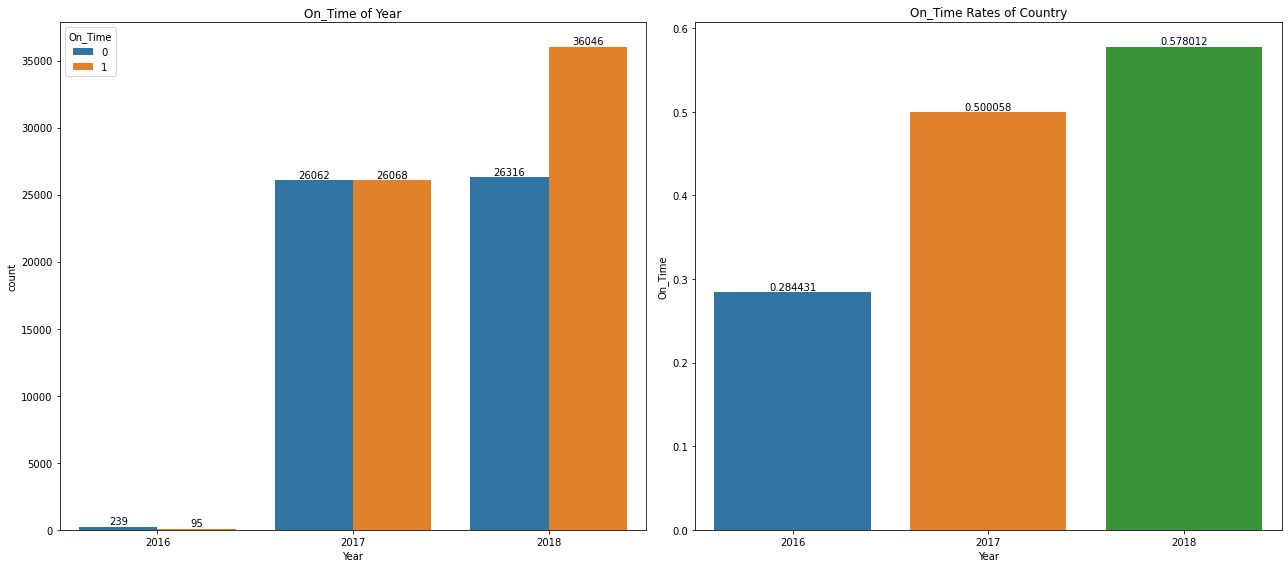

In [36]:
# Data Analysis on year
grouped = delivered_analysis[['Year','On_Time']].groupby('Year').mean().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax1=sns.countplot(x='Year',hue='On_Time',data=delivered_analysis, ax=ax[0])
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title('On_Time of Year')
ax2=sns.barplot(x='Year',y='On_Time',data=grouped, ax=ax[1])
ax2.bar_label(ax2.containers[0])
ax[1].set_title('On_Time Rates of Country')
plt.tight_layout()
plt.show()

### Febuary has lowest on-time rate, June,July,August have more orders and higher on-time rate.

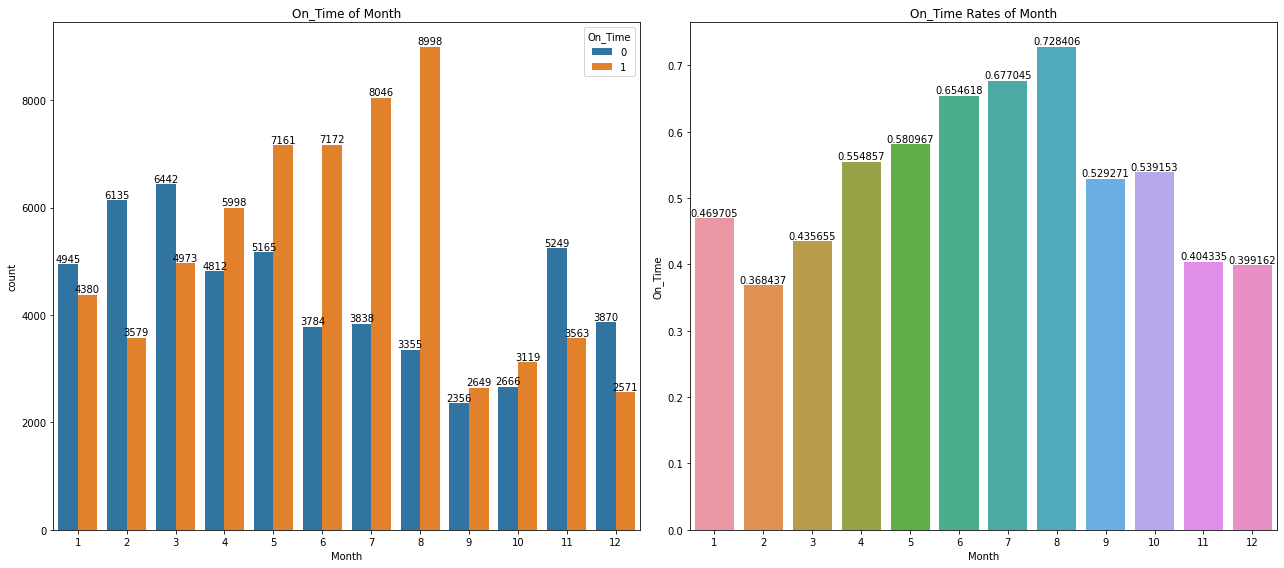

In [37]:
# Data Analysis on Month
grouped = delivered_analysis[['Month','On_Time']].groupby('Month').mean().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax1=sns.countplot(x='Month',hue='On_Time',data=delivered_analysis, ax=ax[0])
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title('On_Time of Month')
ax2=sns.barplot(x='Month',y='On_Time',data=grouped, ax=ax[1])
ax2.bar_label(ax2.containers[0])
ax[1].set_title('On_Time Rates of Month')
plt.tight_layout()
plt.show()

### Top 10 most orders citis except Salvador have better on-time delivery rate

In [38]:
city = list(delivered_analysis['customer_city'].value_counts().sort_values(ascending=False).head(10).index)
state_analysis=delivered_analysis['customer_city'].isin(city)
state_analysis=delivered_analysis[state_analysis]

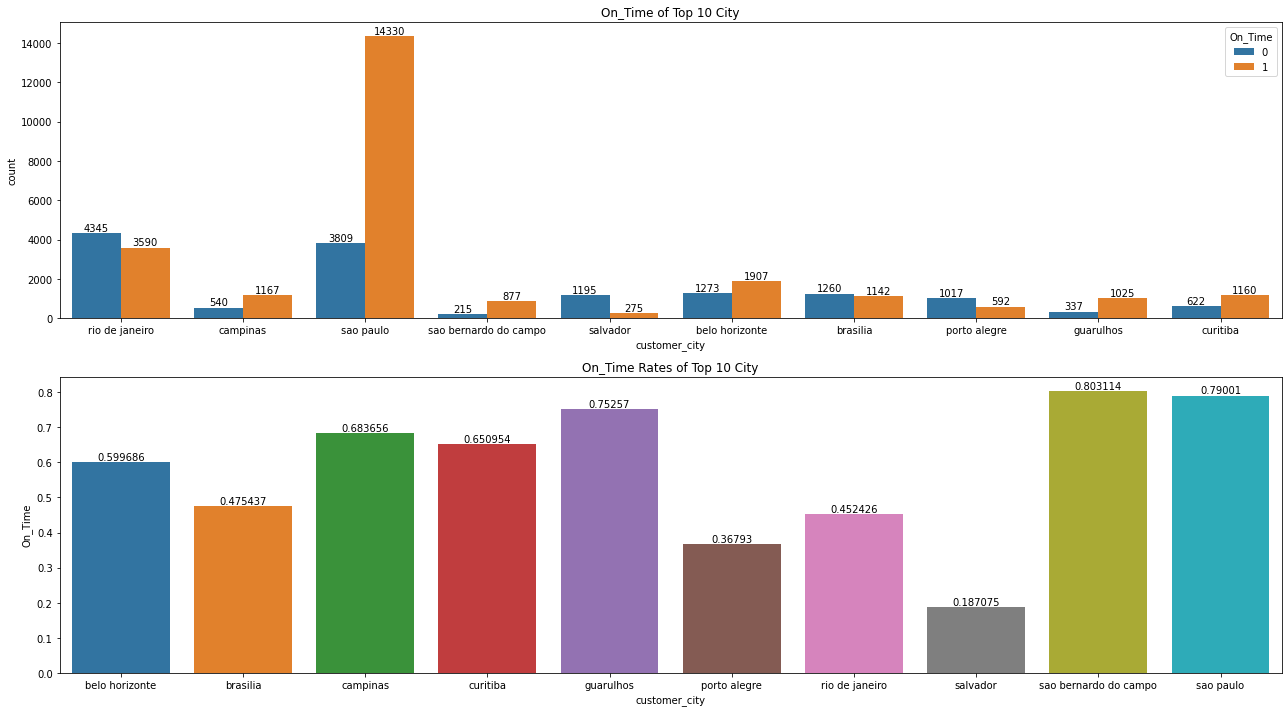

In [39]:
# Data Analysis on customer_city
grouped = state_analysis[['customer_city','On_Time']].groupby('customer_city').mean().reset_index()
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18,10))
ax1=sns.countplot(x='customer_city',hue='On_Time',data=state_analysis, ax=ax[0])
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title('On_Time of Top 10 City')
ax2=sns.barplot(x='customer_city',y='On_Time',data=grouped, ax=ax[1])
ax2.bar_label(ax2.containers[0])
ax[1].set_title('On_Time Rates of Top 10 City')
plt.tight_layout()
plt.show()

## Random Forest

In [40]:
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [41]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.20.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.20.04.1, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpigs890ge
  JVM stdout: /tmp/tmpigs890ge/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpigs890ge/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,2 months and 24 days
H2O_cluster_name:,H2O_from_python_unknownUser_q7jn8q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.396 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [42]:
# Transform to H2O Frame and make sure the target variable is categorical
h2o_df = H2OFrame(dataset.dropna())
h2o_df.summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,price,customer_city,product_weight_g,Month,processing time,shipping time,On_Time,Year
type,real,enum,int,int,int,int,int,int
mins,0.85,,0.0,1.0,0.0,-17.0,0.0,2016.0
mean,120.10861644861812,,2108.4570405727795,6.033142867097513,2.8007247007996097,8.747487065135957,0.5417573994390537,2017.5402853509445
maxs,6735.0,,40425.0,12.0,125.0,205.0,1.0,2018.0
sigma,183.07070046233505,,3775.624133036701,3.2299377143411787,3.6342435206728685,8.616484298358046,0.49825543851462384,0.5041803406305242
zeros,0,,8,0,22277,3278,52609,0
missing,0,0,0,0,0,0,0,0
0,58.9,campos dos goytacazes,650.0,9.0,6.0,1.0,1.0,2017.0
1,239.9,santa fe do sul,30000.0,4.0,8.0,8.0,0.0,2017.0
2,199.0,para de minas,3050.0,1.0,1.0,6.0,1.0,2018.0


In [43]:
strat_split = h2o_df['On_Time'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['price','customer_city','product_weight_g','Month','processing time','shipping time','On_Time','Year']
target = 'On_Time'

train

price,customer_city,product_weight_g,Month,processing time,shipping time,On_Time,Year
58.9,campos dos goytacazes,650,9,6,1,1,2017
239.9,santa fe do sul,30000,4,8,8,0,2017
199,para de minas,3050,1,1,6,1,2018
12.99,atibaia,200,8,2,4,1,2018
199.9,varzea paulista,3750,2,11,13,0,2017
21.9,uberaba,450,5,1,5,1,2017
810,praia grande,13805,7,1,4,1,2018
145.95,santos,2000,3,8,1,1,2018
53.99,jandira,850,7,1,1,1,2018
59.99,piracicaba,950,3,2,1,1,2018


In [44]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train,validation_frame = test)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1660942006585_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,3828344.0,20.0,20.0,20.0,1149.0,2783.0,1879.08




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.013410666867956483
RMSE: 0.11580443371458833
MAE: 0.035765738694034585
RMSLE: 0.08097263835271479
Mean Residual Deviance: 0.013410666867956483

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.012965426920588836
RMSE: 0.11386582859044603
MAE: 0.036319688372153366
RMSLE: 0.07917231668570562
Mean Residual Deviance: 0.012965426920588836

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2022-08-19 20:46:58,0.325 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-08-19 20:46:59,1.617 sec,1.0,0.167629,0.029293,0.028099,0.173805,0.031413,0.030208
2,,2022-08-19 20:46:59,1.967 sec,2.0,0.156931,0.027974,0.024627,0.144398,0.029982,0.020851
3,,2022-08-19 20:47:00,2.272 sec,3.0,0.165249,0.033473,0.027307,0.141386,0.035457,0.019990
4,,2022-08-19 20:47:00,2.657 sec,4.0,0.163133,0.035103,0.026612,0.136180,0.036469,0.018545
5,,2022-08-19 20:47:00,2.933 sec,5.0,0.157476,0.034856,0.024799,0.131426,0.035881,0.017273
6,,2022-08-19 20:47:00,3.205 sec,6.0,0.154617,0.036161,0.023906,0.128766,0.036927,0.016581
7,,2022-08-19 20:47:01,3.508 sec,7.0,0.151028,0.036345,0.022809,0.126726,0.037044,0.016060
8,,2022-08-19 20:47:01,3.848 sec,8.0,0.149627,0.038004,0.022388,0.126263,0.038528,0.015942
9,,2022-08-19 20:47:01,4.086 sec,9.0,0.145836,0.037637,0.021268,0.124277,0.037954,0.015445



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,shipping time,989423.062500,1.000000,0.672816
1,processing time,303323.593750,0.306566,0.206263
2,customer_city,86735.992188,0.087663,0.058981
3,Month,35412.117188,0.035791,0.024081
4,price,23036.353516,0.023283,0.015665
5,product_weight_g,22185.904297,0.022423,0.015087
6,Year,10452.489258,0.010564,0.007108


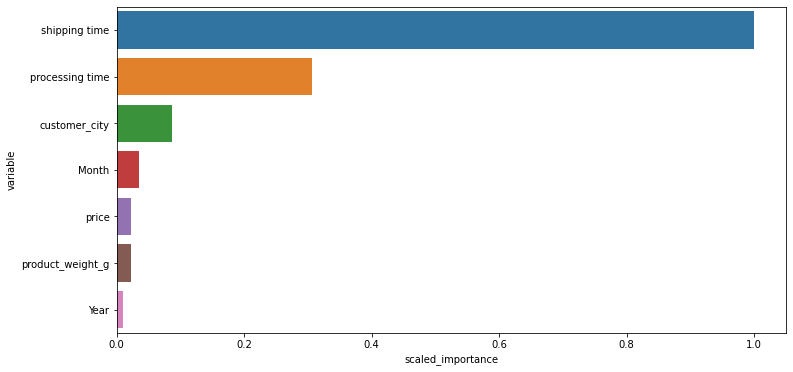

In [45]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [46]:
# retrieve the r2 value:
model.r2()

0.9459805663917544

In [47]:
# retrieve the model performance
perf = model.model_performance(test)
perf


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.012965426920588836
RMSE: 0.11386582859044603
MAE: 0.036319688372153366
RMSLE: 0.07917231668570562
Mean Residual Deviance: 0.012965426920588836


In [48]:
# Make predictions
train_true = train.as_data_frame()['On_Time'].values
test_true = test.as_data_frame()['On_Time'].values
train_pred = model.predict(train).as_data_frame().values
test_pred = model.predict(test).as_data_frame().values

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [49]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

In [50]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     13152
           1       0.98      0.98      0.98     15549

    accuracy                           0.98     28701
   macro avg       0.98      0.98      0.98     28701
weighted avg       0.98      0.98      0.98     28701



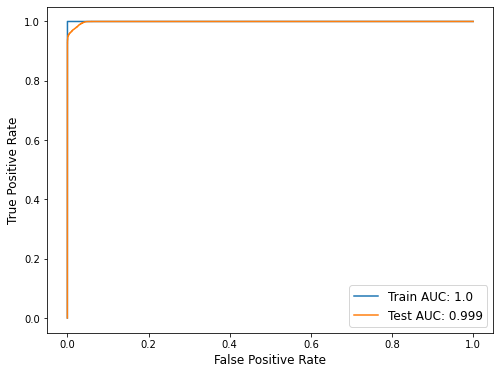

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [52]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_a114 closed.


## Random Forest Concludes:
1. Shipping time has the most impaction on on-time delivery, should get faster delivery service from other carriers. 
2. Saving more time on processing also has great impacts on on-time delivery
3. Customer city has correlation with shipping time. Distance between warehouse and Customer city will influence the shipping time.
4. Product_weight and price don't impact delivery on time. That's good.

# Suggestions:
1. Only 54% of orders consider as on-time if lead time sets as 10 days. That's a pretty low delivery performance. Company should touch with other vendors to get faster shipping service.

2. Time of processing orders has potential to decrease. Orders average processing time is 3 days and 9.3% orders delayed in process. 

3. Although has 3% undelivered rate, Company should work with warehouse department and carriers to avoid missing orders cases.

4. Top 10 customer cities except Salvado have higher on-time rate than average rate. It is clear that international shipments will take more delivery time. Could establish new channel to ship packages to Salvado. In domestic, Brasilia, Porto llegre and Rio de janeiro has great potential to get better on-time delivery.